## Machine Learning and Statistics Project 2020
***


The aim of this project is to create a web service that uses machine learning to make predictions based on the data set 'powerproduction'. The goal is to produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set. Then, to develop a web service that will respond with predicted power values based on speed values sent as HTTP requests.

<br>



<br>

## Introduction

***

There are a number of steps involved in creating an accurate predictive model as described in the project brief. This project follows these steps, providing explanations for the choice of model used through analysis of the *powerproduction* data set. With this in mind, it is divided into the following sections:

* Preliminary Analysis
* Function Approximation (Regression vs Classification)
* Regression with `scikit-learn`
* Regression with `keras`
* Model evaluation

<br>



## 1. Preliminary Analysis

***

First, I import the modules needed and choose a style for visualisation throughout the project:

* `numpy` is a python library which allows us to work with arrays, more suited to data analysis than traditional python `lists` [1] 
* `pandas` is suited to working with data sets and provides the DataFrame structure to make this more effective and efficient [2]. 
* `matplotlib.pyplot` is used for visualisation. It is a graph plotting library on which many visualisation packages are built in python. The `pyplot` submodule contains most of matplotlib's utilities [3]
* With the `scikit-learn` library, we have access to numerous machine learning algorithms [4]. In this project it is used to generate predictive models and also to evaluate those models. 
* `tensorflow` is a machine learning platform with a focus on working with and training neural networks [5]. `keras` is an API built on tensorflow, providing an interface for working with neural networks [6].

In [1]:
# Working with arrays
import numpy as np

# Working with dataframes
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt

# Linear regression algorithm
from sklearn.linear_model import LinearRegression

# Working with more complex variable relationships
from sklearn.preprocessing import PolynomialFeatures

# Metrics for evaluation
from sklearn.metrics import mean_squared_error, r2_score

# Splitting data into train and test sets
from sklearn.model_selection import train_test_split

# Working with neural networks
import tensorflow.keras as kr

In [2]:
# Plot style
plt.style.use('fivethirtyeight')

# Plot size
plt.rcParams['figure.figsize'] = [11, 6]

Next, I read in the dataset using `pandas.read_csv` which stores the data in a pandas dataframe. I assign this to `pp` and output the first 10 rows. With `pandas.describe` we get a statistical summary of the data set:

In [42]:
# Read in data set
pp = pd.read_csv('powerproduction.csv')

# Output first 10 rows
pp.head(10)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


In [43]:
# Output summary statistics of data set
pp.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


The data set contains two continuous variables. To get an overview of the relationship between them, we can plot them using a scatterplot. Visualising this relationship is a useful first step in understanding what predictive model might be suitable. It can also offer other insights, such as the presence of outliers: 

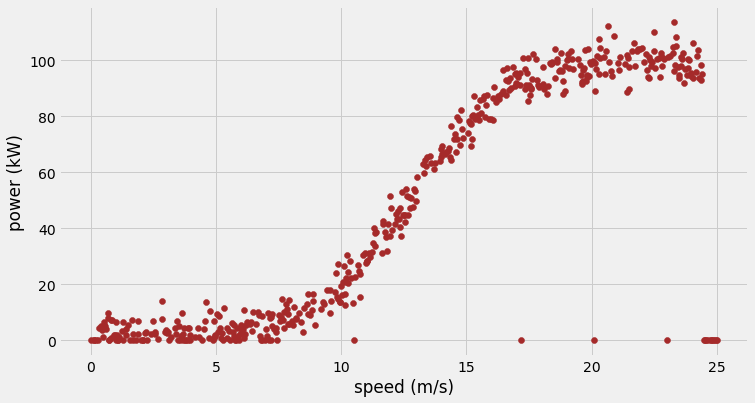

In [44]:
# Plot data on a scatter plot
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.scatter(pp['speed'], pp['power'], color='brown', marker='o')

#### Wind Turbine Power Curve
This plot produces a visualisation of the typical wind turbine power curve. The *cut-in* wind speed is at ~7m/s, below which the turbine is producing hardly any power. Between wind speeds of ~7 and ~17m/s the power ramps up to what is known as the *rated power capacity*. From approximate speeds of ~17m/s the power generated remains constant, right up to ~25m/s, or the *cut-out* wind speed. While there is much potential power in the wind speed above the cut-out speed, the cost of making the turbine capable of producing power under these conditions outweights the benefits of more power being generated [7]. <br>

#### Outliers
What is also notable from the plot is the presence of seeming outliers in the data. There are a number of observations where no power (0kW) is being generated despite sufficiently high wind speeds. This is something which will be examined in greater detail below.

#### What Predictive Model?
Through visualisation we can get a preliminary indication of what model might best be suited when predicting power output from wind speed. Initial inclinations would suggest that this is a *regression* problem. Given that there are only two variables in the data set, simple linear regression may be an appropriate model although fitting a straight line to the data may not yield the most accurate predictions. It might be more suitable to fit a curve. The variables are clearly *positively* correlated between the *cut-in* speed and the *rated power capacity*. 

##### end section 1

<br>



## 2. Function Approximation: Classification vs Regression

***

*Function approximation* is the term used to describe the problem of approximating a mapping function from input variables to output variables. Generally speaking, function approximation problems can be divided into *classification* and *regression* tasks [8]. Deciding between which of these is most appropriate for the current project is the next step.

#### Classification vs Regression
"Classification predictive modeling is the task of approximating a mapping function (f) from input variables (X) to discrete output variables (y)" [9], while the output variables for regression models are continuous numeric variables. The aim of the current project is to predict power output from wind speed. As noted above, this is a continuous numeric variable which tells us that regression is an appropriate model/function for this task.

#### Regression
Regression is a statistical method which describes the relationship between a dependent variable and one or more independent variables [10]. Additionally, it is associated with fitting a line (or curve) to the data by plotting the line over the data points to get the best fit [11]. Taking a look data as plotted on a scatter plot, it is clear that we could fit a line (or curve) in order to accurately predict the dependent variable.



##### end section 2

<br>



## 3. Regression with `scikit-learn`

***

#### scikit-learn

`scikit-learn` is a machine learning library for python programming language. It provides a range of machine learning algorithms and is used widely for the purposes of predictive modelling [12]. In the current project, `scikit-learn`'s `LinearRegression` model will be applied to the *powerproduction* data set. Additionally, the package provides a number of tools which will be used to prepare the data and evaluate the models created below.

#### Outliers

Before applying the linear regression model to the data set, it is important to remove any outliers so that the data we train and test the model on most accurately represents the situation at hand. The removal of outliers must be handled sensitively and cautiously so as not to misrepresent the data, and because every data set is different, there is often a lack of clearly defined rules around how to deal with them [13]. As we saw above, visualisation can give us a strong indication that some of the observations may need to be removed. However, statistical methods can also be used to detect extreme or unlikely values in a data set. 

#### Mahalonibis Distance

In researching outlier detection, much of the online resources appeared to deal with *univariate* outliers [14], [15]. Additionally, detection tools available as part of the `scikit-learn` library e.g. `LocalOutlierFactor`, (which uses the nearest neighbours algorithm to detect outliers in a sample) were not suited to the current project. For *multivariate* outliers, a common statistical method of dection is the *Mahalonibis Distance* measure, which is "... widely used distance metric for the detection of multivariate outliers..." [16]. Indeed it has been applied to wind turbine curve modeling by a number of studies (e.g. Pei and Li, 2019) [17]. 

The code below was found on an informative blog post [18] and applies Mahalonibis Distance to the data set to detect outliers. This function returns a list of outliers as detected by the method:

In [62]:
#import copy 
import scipy as sp
from scipy.stats import chi2
from sklearn.covariance import MinCovDet


#Robust Mahalonibis Distance
def robust_mahalanobis_method(df):
    #Minimum covariance determinant
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)
    X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size=506)
    cov = MinCovDet(random_state=0).fit(X)
    mcd = cov.covariance_ #robust covariance metric
    robust_mean = cov.location_  #robust mean
    inv_covmat = sp.linalg.inv(mcd) #inverse covariance metric
    
    #Robust M-Distance
    x_minus_mu = df - robust_mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Flag as outlier
    outlier = []
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))#degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

outliers_mahal_rob, md_rb = robust_mahalanobis_method(df=df)

In [63]:
# List of index values containing outliers
outliers_mahal_rob

[340, 404, 456, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499]

In [65]:
# Find rows containing outlier indices
pp_outliers = pp.loc[ outliers_mahal_rob , : ]

In [66]:
# Output dataframe of outliers
pp_outliers

,speed,power
340,17.167,0.0
404,20.095,0.0
456,22.998,0.0
490,24.499,0.0
491,24.525,0.0
492,24.575,0.0
493,24.650,0.0
494,24.750,0.0
495,24.775,0.0
496,24.850,0.0


Above is the data frame containing the outlier observations. All the outliers detected have a power value of 0kW. This is what was observed in the scatterplot.

#### Simple linear regression

Simple linear regression is "... the simplest case of linear regression with a single independent variable" [14]. The *powerproduction* data set contains one independent variable (speed) and one dependent variable (power).  function imported from Python's Scikit-learn library to produce a model. Simple linear regression can be applied when the data set contains only two variables - a dependent and independent variable. This is a condition which is filled by the 'powerproduction' data set.

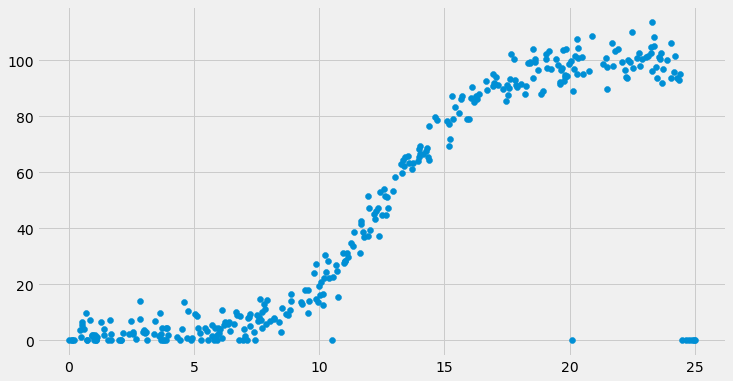

In [47]:
plt.scatter(X_train, y_train)

<br>



<br>

First, the data set is split into two separate columns in order to train the model.

In [7]:
# Create a new dataset containing only values from the speed column and print output
speed_df = pp.drop('power',axis='columns')
speed_df

,speed
0,0.000
1,0.125
2,0.150
3,0.225
4,0.275
...,...
495,24.775
496,24.850
497,24.875
498,24.950


In [8]:
# Create a new dataset containing only values from the power column and print output 
power_df = pp.drop('speed',axis='columns')
power_df

,power
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
495,0.0
496,0.0
497,0.0
498,0.0


<br>

Next, I create an instance of the LinearRegression() class and call the `fit` method, passing the speed and power dataframes as arguments. 

In [9]:
# Create an instance of the LinearRegression() class
reg = LinearRegression()

# Fit our data to the model
reg.fit(speed_df, power_df)

LinearRegression()

Once this is done, we can now test the model for accuracy. We can do this by calling a number of methods provided by the functionality of the `LinearRegresssion()` class.

<br>

First, I take a pick a value for speed and pass it to the `.predict` method

In [10]:
# Predict method using a value for speed
email = 10.89
arr = reg.predict([[9.746]])

<br>

Next, I call the `intercept_` method to determine where the line intercepts the y-axis. And below that I use call `coef_` to get the slope of the line. This gives us all the values for formula for the best-fitting line: $$y = mx + b$$ where m is the slope, b is the y-interept and x is the independent variable [3].

[3] dummies.com; How to calculate a regression line; https://www.dummies.com/education/math/statistics/how-to-calculate-a-regression-line/ <br>

In [11]:
# Call the intercept_ method to determine where the line intercepts the y-axis
reg.intercept_

array([-13.89990263])

In [12]:
# Call the coef_ method to calculate the slope of the line
reg.coef_

array([[4.91759567]])

In [13]:
# Set calculated values
m = 4.91759567
x = 9.746
b = -13.899902630519641

y = m*x + b
print(y)

34.02698476930036


As expected, we get the same result for y when we input these values into the formula (above)
<br>



### R-squared 

The `LinearRegression` class also provides functionality for calculating the the R-squared value. The R-squared value is a 'goodness-of-fit' measure which can give us an indication as to the accuracy of our regression model. The best possible score is 1.0, while a score of 0 or a negative value generally represents a worse-fitting line. The R-squared value "indicates the percentage of the variance in the dependent variable that the independent variables explain collectively." [4] It is worth noting that a high R-squared does not necessarily always indicate the best fit [5].

[4] Frost, J; How To Interpret R-squared in Regression Analysis; https://statisticsbyjim.com/regression/interpret-r-squared-regression/ <br>
[5] *Ibid*

In [14]:
# Calculate R-squared value
reg.score(speed_df, power_df)

0.7289360258564072

<br>


***

### Train_test_split

The train-test-split procedure involves training a machine learning algorithm by splitting the data into separate proportions. One proportion (train) is used to train the model while the other (test) is held back in order to test its accuracy. (It is worth pointing out that it may not always be appropriate as a technique to increase accuracy of prediction e.g. if the data set is too small [6].) 

<br>

Below, I pass the speed_df and power_df dataframes to the `train_test_split` method and set the parameter *test_size* to 0.2. The test size indicates the size of the train and test sets. Common split percentages include 
* Train: 80%, Test: 20%
* Train: 67%, Test: 33%
* Train: 50%, Test: 50% [7]


[6] machinelearningmastery.com; Train-Test Split for Evaluating Machine Learning Algorithms; https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/ <br>
[7] *Ibid*

In [15]:
# Call train_test_split method on dataframes
A_Train, A_Test, B_Train, B_Test = train_test_split(speed_df, power_df, test_size = 0.2)

In [16]:
pp = pp[pp.power != 0]


In [17]:
x = pp['speed']
y = pp['power']

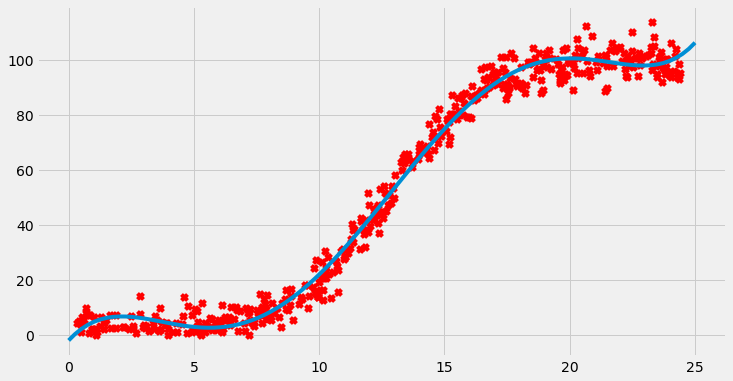

In [18]:
mymodel = np.poly1d(np.polyfit(x, y, 6))

myline = np.linspace(0, 25, 100)

plt.scatter(x, y, color='red', marker='x')
plt.plot(myline, mymodel(myline))
plt.show()


## Neural network - Regression

***

In [19]:
pp = pp[pp.power != 0]
pp.describe()

,speed,power
count,451.000000,451.000000
mean,13.004302,53.231246
std,6.835979,40.522055
min,0.325000,0.067000
25%,7.344500,8.543500
50%,13.038000,58.168000
75%,18.781500,94.725500
max,24.399000,113.556000


In [20]:
# Create neural network with one neuron
def create_model():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')
    
    return model

In [21]:
model = create_model()

In [22]:


msk = np.random.rand(len(pp)) < 0.5
train = pp[msk]

test = pp[~msk]

In [23]:
model.fit(train['speed'], train['power'], epochs=500, batch_size=10)

Epoch 1/500
23/23 [==============================] - 2s 3ms/step - loss: 3979.0445
Epoch 2/500
23/23 [==============================] - 0s 4ms/step - loss: 3509.7066
Epoch 3/500
23/23 [==============================] - 0s 3ms/step - loss: 1733.3115
Epoch 4/500
23/23 [==============================] - 0s 3ms/step - loss: 501.0028
Epoch 5/500
23/23 [==============================] - 0s 3ms/step - loss: 269.2217
Epoch 6/500
23/23 [==============================] - 0s 3ms/step - loss: 295.2341
Epoch 7/500
23/23 [==============================] - 0s 3ms/step - loss: 252.3710
Epoch 8/500
23/23 [==============================] - 0s 4ms/step - loss: 227.6657
Epoch 9/500
23/23 [==============================] - 0s 3ms/step - loss: 244.0547
Epoch 10/500
23/23 [==============================] - 0s 3ms/step - loss: 242.9297
Epoch 11/500
23/23 [==============================] - 0s 3ms/step - loss: 240.9219
Epoch 12/500
23/23 [==============================] - 0s 3ms/step - loss: 203.8299
Epoch 13/5

23/23 [==============================] - 0s 3ms/step - loss: 128.1529
Epoch 100/500
23/23 [==============================] - 0s 3ms/step - loss: 114.5214
Epoch 101/500
23/23 [==============================] - 0s 3ms/step - loss: 110.6666
Epoch 102/500
23/23 [==============================] - 0s 2ms/step - loss: 97.7666
Epoch 103/500
23/23 [==============================] - 0s 3ms/step - loss: 119.5600
Epoch 104/500
23/23 [==============================] - 0s 3ms/step - loss: 112.3085
Epoch 105/500
23/23 [==============================] - 0s 3ms/step - loss: 103.1622
Epoch 106/500
23/23 [==============================] - 0s 3ms/step - loss: 123.6254
Epoch 107/500
23/23 [==============================] - 0s 3ms/step - loss: 109.9642
Epoch 108/500
23/23 [==============================] - 0s 2ms/step - loss: 106.9010
Epoch 109/500
23/23 [==============================] - 0s 2ms/step - loss: 100.7855
Epoch 110/500
23/23 [==============================] - 0s 2ms/step - loss: 109.4546
Epoch 1

23/23 [==============================] - 0s 3ms/step - loss: 83.2035
Epoch 198/500
23/23 [==============================] - 0s 3ms/step - loss: 89.4119
Epoch 199/500
23/23 [==============================] - 0s 4ms/step - loss: 70.3361
Epoch 200/500
23/23 [==============================] - 0s 3ms/step - loss: 63.0512
Epoch 201/500
23/23 [==============================] - 0s 3ms/step - loss: 66.9669
Epoch 202/500
23/23 [==============================] - 0s 3ms/step - loss: 70.0281
Epoch 203/500
23/23 [==============================] - 0s 3ms/step - loss: 74.0512
Epoch 204/500
23/23 [==============================] - 0s 3ms/step - loss: 66.1468
Epoch 205/500
23/23 [==============================] - 0s 3ms/step - loss: 75.3618
Epoch 206/500
23/23 [==============================] - 0s 3ms/step - loss: 68.0974
Epoch 207/500
23/23 [==============================] - 0s 3ms/step - loss: 67.9654
Epoch 208/500
23/23 [==============================] - 0s 3ms/step - loss: 64.4474
Epoch 209/500
23/2

23/23 [==============================] - 0s 3ms/step - loss: 33.7658
Epoch 296/500
23/23 [==============================] - 0s 3ms/step - loss: 32.7747
Epoch 297/500
23/23 [==============================] - 0s 3ms/step - loss: 28.3474
Epoch 298/500
23/23 [==============================] - 0s 3ms/step - loss: 33.2103
Epoch 299/500
23/23 [==============================] - 0s 3ms/step - loss: 40.2735
Epoch 300/500
23/23 [==============================] - 0s 2ms/step - loss: 33.0705
Epoch 301/500
23/23 [==============================] - 0s 2ms/step - loss: 33.1197
Epoch 302/500
23/23 [==============================] - 0s 2ms/step - loss: 32.0204
Epoch 303/500
23/23 [==============================] - 0s 2ms/step - loss: 31.7258
Epoch 304/500
23/23 [==============================] - 0s 3ms/step - loss: 32.2691
Epoch 305/500
23/23 [==============================] - 0s 2ms/step - loss: 29.4661
Epoch 306/500
23/23 [==============================] - 0s 3ms/step - loss: 30.9871
Epoch 307/500
23/2

23/23 [==============================] - 0s 3ms/step - loss: 21.0292
Epoch 394/500
23/23 [==============================] - 0s 3ms/step - loss: 21.0388
Epoch 395/500
23/23 [==============================] - 0s 3ms/step - loss: 21.0218
Epoch 396/500
23/23 [==============================] - 0s 4ms/step - loss: 19.8777
Epoch 397/500
23/23 [==============================] - 0s 3ms/step - loss: 21.0982
Epoch 398/500
23/23 [==============================] - 0s 3ms/step - loss: 23.8841
Epoch 399/500
23/23 [==============================] - 0s 3ms/step - loss: 18.7339
Epoch 400/500
23/23 [==============================] - 0s 3ms/step - loss: 22.0267
Epoch 401/500
23/23 [==============================] - 0s 3ms/step - loss: 24.1379
Epoch 402/500
23/23 [==============================] - 0s 3ms/step - loss: 23.1535
Epoch 403/500
23/23 [==============================] - 0s 3ms/step - loss: 23.1623
Epoch 404/500
23/23 [==============================] - 0s 3ms/step - loss: 24.1392
Epoch 405/500
23/2

23/23 [==============================] - 0s 3ms/step - loss: 20.9292
Epoch 492/500
23/23 [==============================] - 0s 2ms/step - loss: 21.2975
Epoch 493/500
23/23 [==============================] - 0s 3ms/step - loss: 19.3664
Epoch 494/500
23/23 [==============================] - 0s 3ms/step - loss: 20.7172
Epoch 495/500
23/23 [==============================] - 0s 3ms/step - loss: 25.9695
Epoch 496/500
23/23 [==============================] - 0s 3ms/step - loss: 19.9384
Epoch 497/500
23/23 [==============================] - 0s 3ms/step - loss: 19.5982
Epoch 498/500
23/23 [==============================] - 0s 3ms/step - loss: 23.1655
Epoch 499/500
23/23 [==============================] - 0s 4ms/step - loss: 19.8264
Epoch 500/500
23/23 [==============================] - 0s 3ms/step - loss: 18.8735


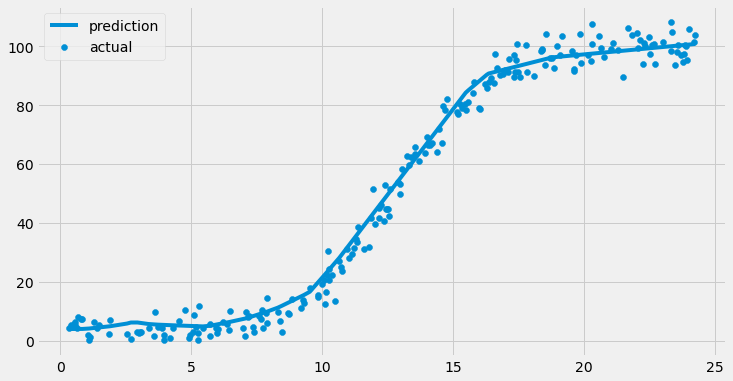

In [24]:
plt.scatter(test['speed'], test['power'], label='actual')
plt.plot(test['speed'], model.predict(test['speed']), label='prediction')
plt.legend()

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 10,401
Trainable params: 10,401
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.save('my_model.h5')

In [27]:
model.predict([14])

array([[66.96124]], dtype=float32)

In [28]:
lin_x = pp.speed[:, np.newaxis]
lin_y = pp.power[:, np.newaxis]

<ipython-input-28-5eafad447be6>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lin_x = pp.speed[:, np.newaxis]
<ipython-input-28-5eafad447be6>:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lin_y = pp.power[:, np.newaxis]


In [29]:
polynomial_features= PolynomialFeatures(degree=5)
x_poly = polynomial_features.fit_transform(lin_x)

In [30]:
lin_model = LinearRegression()
lin_model.fit(x_poly, lin_y)
y_poly_pred = lin_model.predict(x_poly)

In [31]:

rmse = np.sqrt(mean_squared_error(lin_y,y_poly_pred))
r2 = r2_score(lin_y,y_poly_pred)
print(rmse)
print(r2)

4.438058874744193
0.9879782627661895


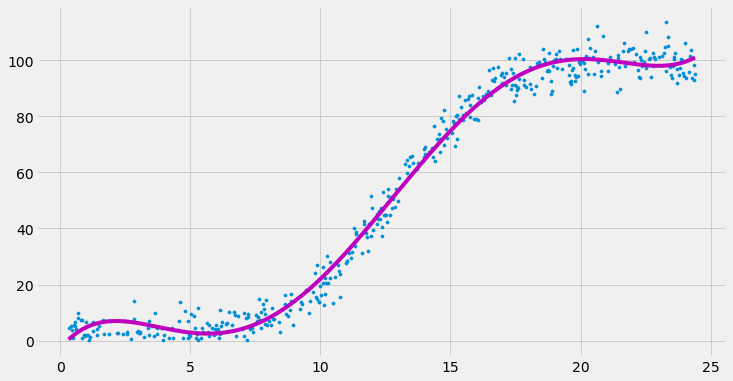

In [32]:

plt.scatter(lin_x, lin_y, s=10)
# sort the values of x before line plot
# sort_axis = operator.itemgetter(0)
# sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
# x, y_poly_pred = zip(*sorted_zip)
plt.plot(lin_x, y_poly_pred, color='m')
plt.show()

In [33]:
np.random.seed(0)
x = 2 - 3 * np.random.normal(0, 1, 20)
y = x - 2 * (x ** 2) + 0.5 * (x ** 3) + np.random.normal(-3, 3, 20)

# transforming the data to include another axis
x = x[:, np.newaxis]
y = y[:, np.newaxis]

polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)

10.120437473614711
0.8537647164420812


### References

[1] w3schools.com; Numpy Introduction; https://www.w3schools.com/python/numpy_intro.asp <br>
[2] w3schools.com; Pandas Tutorial https://www.w3schools.com/python/pandas_tutorial.asp <br>
[3] w3schools.com; Matplotlib Pyplot; https://www.w3schools.com/python/matplotlib_pyplot.asp <br>
[4] wikipedia.org; scikit_learn https://en.wikipedia.org/wiki/Scikit-learn <br>
[5] tensorflow.org; https://www.tensorflow.org/ <br>
[6] keras.io; https://keras.io/ <br>
[7] youtube.com; Wind Turbine Power Curve description; https://www.youtube.com/watch?v=8tNOL4ZL9Do <br>
[8] Brownlee, J.; Difference Between Classification and Regression in Machine Learning https://machinelearningmastery.com/classification-versus-regression-in-machine-learning/ <br>
[9] *Ibid* <br>
[10] Wikipedia.org; Regression analysis; https://en.wikipedia.org/wiki/Regression_analysis <br>
[11] yale.edu; Linear Regression; http://www.stat.yale.edu/Courses/1997-98/101/linreg.htm <br>
[12] wikipdeia.org; scikit-learn; https://en.wikipedia.org/wiki/Scikit-learn <br>
[13] Brownlee, J; How to Remove Outliers for Machine Learning; https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/ <br>
[14] *Ibid* <br>
[15] Frost, J; 5 Ways to Find Outliers in Your Data; https://statisticsbyjim.com/basics/outliers/ <br>
[16] Detecting And Treating Outliers In Python — Part 2; https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33 <br>
[17] Pei, S. and Li, P., 2019; Wind Turbine Power Curve Modeling with a Hybrid Machine Learning Technique; https://www.researchgate.net/publication/337325612_Wind_Turbine_Power_Curve_Modeling_with_a_Hybrid_Machine_Learning_Technique <br>
[14] realpython.com; Linear Regression in Python; https://realpython.com/linear-regression-in-python/ <br>